# **HATE SPEECH DETECTION USING LSTM AND BILSMT ON KAGGLE**

**REFERENCE**: The implementation here is a combination of different implementations: <br>
[1] Pinkesh Badjatiya and Shashank Gupta in "Deep Learning for Hate Speech Detection" (to appear in WWW'17 proceedings) (2017) at https://github.com/pinkeshbadjatiya/twitter-hatespeech <br>
[2] Adil Emre Bilgic(June, 2021) "Sentiment Analysis Hate Speech at https://www.kaggle.com/adilemrebilgic/sentiment-analysis-hate-speech/notebook<br>
[3] Srishti Bhalla(Feb 2019) in Hate-Speech-Detection-on-Twitter-Data at https://github.com/srishb28/Hate-Speech-Detection-on-Twitter-Data trained on the dataset of Zeerak et. al. at https://github.com/ZeerakW/hatespeech mentioned also in the report<br>
[4] Deephate: Paper: Cao, R., Ka-Wei Lee, R., Hoang, T.A.: DeepHate: Hate Speech Detection via Multi-Faceted Text Representations. In: WebSci ’20: 12th ACM Conference on Web Science, July 2020 Pages 11–20 (October 2020) https://gitlab.com/bottle_shop/safe/deephate/-/tree/master/DeepHate<br><br>

In this notebook we present the approach as we are trying to detect hate speech in tweets of the Kaggle dataset. The dataset is distributed as hate(sexist/racist) and non-hate. The label '1' denotes the tweet is racist/sexist and label '0' is non-hate.

There are two models: LSTM and BiLSTM. We train the models on Kaggle dataset, where we split on **80%** for training and **20%** on testing. The data is not shuffled in order to have a fair comparison between other models presented in the paper i.e Deephate and TFIDF Based Model.

> The model is a simple LSTM network with **128** unit in the hidden layer and a drop out rate of `0.2` and a reccurrent droput rate of `0.4`. There is one dense layer at the end with 1 unit and an activation function as sigmoid (since we are trying to predict binary labels `0` and `1`). We use `binary_cross_entropy` loss as well. 

The models are trained for different number of epochs (ranging from 1-35) and you can have a look at the accuracy and training plot below, with respective comments.
<br><br><br>
**Table of Contents:**<br><br>

---
HATE SPEECH DETECTION USING LSTM AND BILSMT ON KAGGLE
1. Imports and Preleminaries
2. Data Cleaning
 - Text Pre-Processing
 - Cleaning Pipeline
 - Data Preparation
3. LSTM and BiLSTM Models
4. Training
5. Model Training
 - Word Embeddings
    - One-Hot Vector Representation
    - Train The Model
 - Simple Word2Vec Embedding Model
    - Train the model
 - GloVE Pretrained Embedding
    - Train the model

<br><br><br>
How to run the notebook?

---


1.   Start the notebook and run every cell
2.   Make sure to have all packages installed. It might be better if you use Google Colab or Kaggle as they already have most of the packages available for usage
3.   Packages to be installed: Numpy, Pandas, Matplotlib, Seaborn, Tensorflow, nltk, keras, and genism
4.   Then you can just run the notebook as usuall and enjoy the result :)
5.   If anything happens please contact as to our email address as noted on the submission lab report. 
---

<br>
Thank you for your understanding!



## Imports and Preleminaries

In [ ]:
#importing libraries and organize them
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import tensorflow as tf
import nltk
import keras.utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Input, Bidirectional, GlobalMaxPool1D, LeakyReLU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Word2vec model would be used to train an word 2 vec model used to initialize the weights of the Embedding layer...
from gensim.models import Word2Vec

In [ ]:
# You can use tensorboard model to generate logs beside using matplot libs.
# Tensorflow displays more user friendly plots. 
# I am not sure if this works in a normal jupyter notebook but in Colab it is working fine.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
# Download necessary stopwords and punctuation from nltk if you do not have them
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

You can use this function to mount your google drive to the google colab. Since you can store a lot of data in Google drive with this function is easier to access that data, rather than to reupload it several times after restarting the notebook. If you are running on a local jupyter notebook then there is no need to run this cell, just link the necessary files accordingly.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Get the data to Google Colab. You can use this cell to upload the data or even drag the data manually to the folder you wish. Notice that this might affect the path of the file accordingly. If you are running on a local jupyter notebook then there is no need to run this cell.

In [ ]:
from google.colab import files
# Upload files to google colab in case drag-drop option is not working
# This is the case with my instance (maybe slow internet connection)
# The file will be saved in '\content\name_of_file' directory
dataset_file_dict = files.upload()

Saving kaggle.csv to kaggle.csv


Let's see how the data looks like:

In [ ]:
# get the dataset (Be aware that the name of the dataset might change due to different submission versions)
kaggle_ds = pd.read_csv("/content/kaggle.csv")
kaggle_ds.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## Data Cleaning

In [ ]:
# checking for null values
kaggle_ds.isnull().sum()

id       0
label    0
tweet    0
dtype: int64


**There are NO NULL VALUES found as expected** since the dataset is already a processed one and most of the bad content is removed. However there is still some preprocessing left.

In [ ]:
# defining dependent and independent vectors
# taking only title for prediction
x = kaggle_ds.iloc[:,2:3]
y = kaggle_ds['label']

In [ ]:
kaggle_ds['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

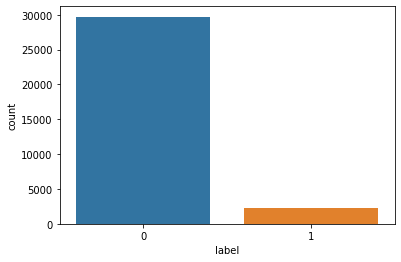

In [ ]:
# Lets see how the data is distributed on hate and non hate
sns.countplot(x = 'label',data = ds)

There are around 30000 tweets labeled as 0(non-hate) and around 2500 labeled as hate or 1. Datase is heavily skewed and most tweets are considered as offensive.

Let's also check the length of the tweet so we can then use padding in the further steps below. As you can notice from the graph the tweets seem to be less than 35 tokens long so I suppose the number 50 in training would be enough.

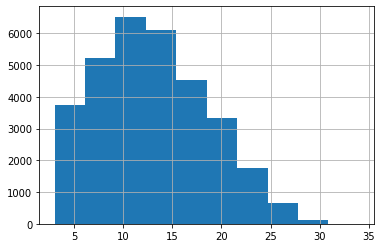

In [ ]:
kaggle_ds['tweet'].str.split().map(lambda x: len(x)).hist()

## Text Pre-Processing

This is rather a simple cleaning pipeline:


1.   Remove special characters and leave only letters.
2.   Lowercase all letters and split the text
3.   Remove emojis/links/usernames and normalize hash tags.
4.   Apply stemming on the data to fix the influence of the bad words
5.   Remove all the stopwords as they are do not contain a lot of information stored. 
6.   Create a sequence again

> This method was part of the Deephate project found in the submission folder in gitlab. We tried to align our methods in order to have a much more fair comparison. However, in LSTM we also make use of Stemming as we believe this might be a factor that influence the learning of the model

### Cleaning Pipleine
The cleaning is similar to deephate.
Reference: Code implementation for the paper "DeepHate: Hate Speech Detection via Multi-Faceted Text Representations" (WebSci'20) Roy Lee (2021) at https://gitlab.com/bottle_shop/safe/deephate/-/blob/master/DeepHate/dataset.py

In [ ]:
def expand_match(contraction):
    contraction_mapping = {
        "isn't": "is not",
        "aren't": "are not",
        "con't": "cannot",
        "can't've": "cannot have",
        "you'll've": "your will have",
        "you're": "you are",
        "you've": "you have"
    }
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match) \
        if contraction_mapping.get(match) \
        else contraction_mapping.get(match.lower())
    expanded_contraction = first_char + expanded_contraction[1:]
    return expanded_contraction

In [ ]:
def clean_tweets(text):
    url_pattern = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')
    emojis_pattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    hash_pattern = re.compile(r'#\w*')
    single_letter_pattern = re.compile(r'(?<![\w\-])\w(?![\w\-])')
    blank_spaces_pattern = re.compile(r'\s{2,}|\t')
    reserved_pattern = re.compile(r'(RT|rt|FAV|fav|VIA|via)')
    mention_pattern = re.compile(r'@\w*')
    CONTRACTION_MAP = {
        "isn't": "is not",
        "aren't": "are not",
        "con't": "cannot",
        "can't've": "cannot have",
        "you'll've": "your will have",
        "you're": "you are",
        "you've": "you have"
    }
    constraction_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())),
                                        flags=re.IGNORECASE | re.DOTALL)
    Whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
    urls = re.sub(pattern=url_pattern, repl='', string=text)
    mentions = re.sub(pattern=mention_pattern, repl='', string=urls)
    hashtag = re.sub(pattern=hash_pattern, repl='', string=mentions)
    reserved = re.sub(pattern=reserved_pattern, repl='', string=hashtag)
    reserved = Whitespace.sub(" ", reserved)
    reserved = constraction_pattern.sub(expand_match, reserved)
    punct = "[{}]+".format(string.punctuation)
    punctuation = re.sub(punct, '', reserved)
    single = re.sub(pattern=single_letter_pattern, repl='', string=punctuation)
    blank = re.sub(pattern=blank_spaces_pattern, repl=' ', string=single)
    blank = blank.lower()
    # print blank
    return blank.split()

Let's clean some tweets then...

In [ ]:
# Text Cleaning and preprocessing
cleaned = []
for i in range(0,len(kaggle_ds)):
    # removing words any other than (a-z) and (A-Z)
    # text = re.sub('[^a-zA-Z]',' ', x['tweet'][i]) 
    # converting all words into lower case
    # text = text.lower()
    # tokenizing 
    # text = text.split()
    text = clean_tweets(x['tweet'][i])
    # text = text.split()
    # stemming and removing stopwords
    ps = PorterStemmer()
    text = [ps.stem(words) for words in text if words not in stopwords.words('english')]
    text = ' '.join(text)
    cleaned.append(text)

In [ ]:
# retrieve the cleaned text
cleaned[:5]

['father dysfunct selfish drag kid dysfunct',
 'thank credit cant use caus dont offer wheelchair van pdx',
 'bihday majesti',
 'love take time urð\x9f\x93± \x9f\x98\x99\x9f\x98\x8e\x9f\x91\x84\x9f\x91 \x9f\x92¦\x9f\x92¦\x9f\x92¦',
 'factsguid societi']

## Data Preparation

- Tokenize: Split tweets into words.
- Padding: Make the input same size by padding with 0 (max.len = 50)
- Split into train/test/validation

Preprocessing data, tokenization, and padding to match the input of the network

In [ ]:
data = kaggle_ds
data['tweet'] = cleaned
data['tokenized_sents'] = data.apply(lambda column: word_tokenize(column['tweet']), axis=1)

In [ ]:
def process_data(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['tokenized_sents'])
    sequences = tokenizer.texts_to_sequences(data['tokenized_sents'])
    # Pad the sequence in order to have max length...
    x = pad_sequences(sequences, maxlen=50)
    y = np.array(data['label'])
    # splitting the Dataset into Train and Test set
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0, shuffle=False)
    # x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=0)
    # print('Train\t0:\t', len(np.where(y_train==0)[0]))
    # print('Train\t1:\t', len(np.where(y_train==1)[0]))
    # print('Test\t0:\t', len(np.where(y_test==0)[0]))
    # print('Test\t1:\t', len(np.where(y_test==1)[0]))
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = process_data(data)

In [ ]:
y_train.shape

(25569,)

## LSTM and BiLSTM Models

In [ ]:
def get_lstm_model(vocab_size, input_length, num_features, embeddings_weight=None, weight_trainable=True):
    # creating model using LSTM
    model = Sequential()
    # taking number features as 64
    # vocab_size = number of unique words in the training set
    if embeddings_weight is not None:
        model.add(Embedding(vocab_size,
                            num_features,
                            input_length = input_length,
                            weights=[embeddings_weight],
                            trainable=weight_trainable))
    else:
        model.add(Embedding(vocab_size, num_features, input_length = input_length))
    model.add(Dropout(0.4))
    # adding LSTM layers with 128 neurons
    model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.4))
    model.add(GlobalMaxPool1D())
    # I added some regularisers to improve the training and to lower overfitting but it actually making little difference
    model.add(Dense(50,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.2))
    # output layer as Dense with sigmoid activation
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    # print model summary
    model.summary()
    return model

In [ ]:
def get_bilstm_model(vocab_size, input_length, num_features, embeddings_weight=None, weight_trainable=True):
    # creating model using BiLSTM
    model = Sequential()
    # taking number features as 64
    if embeddings_weight is not None:
        model.add(Embedding(vocab_size,
                            num_features,
                            input_length = input_length,
                            weights=[embeddings_weight],
                            trainable=weight_trainable))
    else:
        # Random values for the embedding network assigned from keras
        model.add(Embedding(vocab_size, num_features, input_length = input_length))
    model.add(Dropout(0.4))
    # adding Bidirectional LSTM layers with 128 neurons
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.4)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(50,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

## Training

### Model Training
A function which takes different configuration to train our model and then test it on test set, It will print the scores (acc, precision, recall, F1 and the confusion matrix)

In [ ]:
from sklearn.utils import class_weight
def train_model(model, x_train, y_train, x_test, y_test, x_val=None, y_val=None, set_batch_size=64, num_epochs=6, verbose=False, scale_loss=False):
    
    # Stop if the model overfits...
    stop = EarlyStopping(
        monitor='val_accuracy', 
        mode='max',
        patience=5
    )
    # Save model logs during training to the specific folder
    checkpoint= ModelCheckpoint(
        filepath='./',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Lets specify some weights for our class function
    # since the dataset is not really balanced and may cause overfitting
    class_weights = None
    if scale_loss is True:
        pass;

    # training the model
    history = model.fit(x_train,
                        y_train,
                        validation_split=0.2,
                        class_weight=class_weights,
                        epochs=num_epochs,
                        batch_size=set_batch_size,
                        callbacks=[tensorboard_callback, stop, checkpoint])
    # Visualizing training accuracy and loss per epoch to eliminate the potential threat of overfitting
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], 'b', label='training acc')
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['val_accuracy'], 'c', label='val acc')
    plt.title('Accuracy Plot')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['loss'], 'r', label='training loss')
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['val_loss'], 'g', label='val loss')
    plt.legend(loc='best')
    plt.title('Loss Plot')
    plt.ylabel('Error/Loss')
    plt.xlabel('Epochs')
    plt.show()
    # Evaluate the model on the test set and check the accuracy
    evaluation = model.evaluate(x_test, y_test)
    # predicting and getting accuracy
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5)
    # y_pred = [1 if prob==True else 0 for prob in y_pred]
    print(classification_report(y_test, y_pred))
    precision_bi, recall_bi, fscore_bi, support_bi = precision_recall_fscore_support(y_test, y_pred)
    print('\nAccuracy', accuracy_score(y_test,y_pred))
    print('LSTM: non hate - hate')
    print('precision: {}'.format(precision_bi))
    print('recall: {}'.format(recall_bi))
    print('fscore: {}'.format(fscore_bi))
    print('support: {}'.format(support_bi))
    # getting confusion matrix
    print('\nConfusion Matrix: \n', confusion_matrix(y_test,y_pred))
    if verbose == True:
        # Only open tensorboard if specified so
        %load_ext tensorboard
        %tensorboard --logdir logs
    return model

## Word Embeddings

We will test our lstm and bilstm models with different configurations and embeddings types. 
- One-Hot Encoding of the Sequence + Random Embeddings
- Word2Vec Embedding from Genism generated from training data(i.e dataset of 
- GloVe Pretrained Embedding (To do this you need to have the golve embedding file somewhere or to download it from : link...)

In [ ]:
def shuffle_weights(model):
    weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    model.set_weights(weights)

In [ ]:
# Reference: [1] Pinkesh et. al. https://github.com/pinkeshbadjatiya/twitter-hatespeech
from string import punctuation
from collections import defaultdict
def get_vocab(data):
    # Processing
    vocab, reverse_vocab = {}, {}
    freq = defaultdict(int)
    vocab_index = 1
    for text in data:
        for word in text:
            if word not in vocab:
                vocab[word] = vocab_index
                reverse_vocab[vocab_index] = word       # generate reverse vocab as well
                vocab_index += 1
            freq[word] += 1
    vocab['UNK'] = len(vocab) + 1
    reverse_vocab[len(vocab)] = 'UNK'
    return vocab, reverse_vocab, freq

In [ ]:
vocabulary, reverse_vocabulary, frequencies = get_vocab(data['tokenized_sents'])

### One-Hot Vector Representation


You can make the sequence to one hot vector

Our motive here is to create an embedding layer of texts for the LSTM, OneHot encoding prepares our text array into a format required by embedding layer.

In [ ]:
# taking dictionary size 5000
vocab_size = len(vocabulary)
# one hot encoding
one_hot_dir = [one_hot(words, vocab_size) for words in cleaned]
# length of all rows should be equal therefore applying padding
# this will adjust size by adding 0 at staring of the shorter rows
embedded_layer = pad_sequences(one_hot_dir, padding = 'pre')
embedded_layer

array([[    0,     0,     0, ...,  8137, 11419, 22170],
       [    0,     0,     0, ...,  5292,  4865, 10635],
       [    0,     0,     0, ...,     0, 10002,  5431],
       ...,
       [    0,     0,     0, ..., 12199,  9875, 11940],
       [    0,     0,     0, ...,  8099, 14208, 15105],
       [    0,     0,     0, ...,     0, 14472, 21180]], dtype=int32)

In [ ]:
# converting into numpy arrays.
x = np.array(embedded_layer)
y = np.array(kaggle_ds['label'])
# y = to_categorical(data['label'], num_classes=2)
x.shape

(31962, 24)

#### Train The Model

In [ ]:
lstm_model = get_lstm_model(vocab_size, x.shape[1], 50)
# Randomly assigns weight to the network
shuffle_weights(lstm_model)
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0, shuffle=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 24, 50)            1183550   
                                                                 
 dropout_10 (Dropout)        (None, 24, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 24, 128)           91648     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 50)                6450      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50)                0         
                                                      

Epoch 1/6
80/80 [==============================] - 12s 124ms/step - loss: 0.2961 - accuracy: 0.9220 - val_loss: 0.2757 - val_accuracy: 0.9261
Epoch 2/6
80/80 [==============================] - 9s 116ms/step - loss: 0.2656 - accuracy: 0.9306 - val_loss: 0.2667 - val_accuracy: 0.9261
Epoch 3/6
80/80 [==============================] - 9s 116ms/step - loss: 0.2246 - accuracy: 0.9307 - val_loss: 0.2029 - val_accuracy: 0.9327
Epoch 4/6
80/80 [==============================] - 10s 119ms/step - loss: 0.1353 - accuracy: 0.9557 - val_loss: 0.2011 - val_accuracy: 0.9396
Epoch 5/6
80/80 [==============================] - 9s 116ms/step - loss: 0.1053 - accuracy: 0.9680 - val_loss: 0.1979 - val_accuracy: 0.9378
Epoch 6/6
80/80 [==============================] - 9s 118ms/step - loss: 0.0896 - accuracy: 0.9745 - val_loss: 0.2143 - val_accuracy: 0.9386


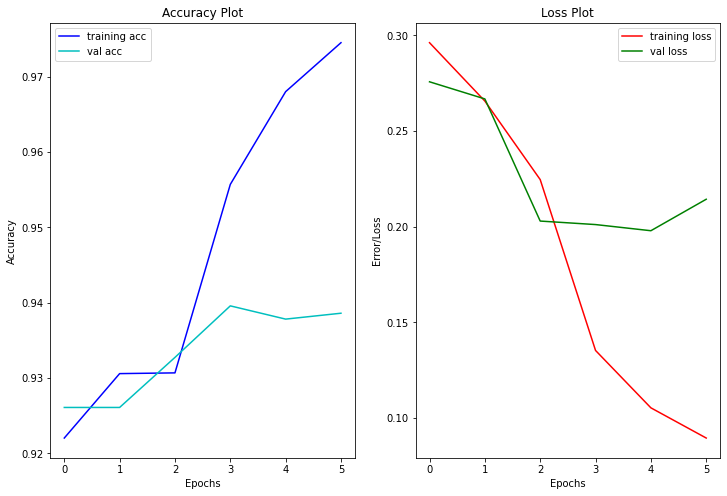

200/200 [==============================] - 2s 9ms/step - loss: 0.1945 - accuracy: 0.9470
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5949
           1       0.70      0.42      0.52       444

    accuracy                           0.95      6393
   macro avg       0.83      0.70      0.75      6393
weighted avg       0.94      0.95      0.94      6393


Accuracy 0.9469732519943689
LSTM: non hate - hate
precision: [0.95773499 0.69811321]
recall: [0.98655236 0.41666667]
fscore: [0.97193012 0.52186178]
support: [5949  444]

Confusion Matrix: 
 [[5869   80]
 [ 259  185]]


In [ ]:
trained_model = train_model(lstm_model, x_train, y_train, x_test, y_test, set_batch_size=256)

### Simple Word2Vec Embedding Model

**Let's do some word2Vec embeddings instead of OneHot Encoding**

We will use the tweets as our corpus to train our word2vec model (From Genism Library).

Train our own model based on he data we have from each tweet.

In [ ]:
# Reference: https://github.com/srishb28/Hate-Speech-Detection-on-Twitter-Data
# define training data
sentences = data['tokenized_sents']
# train model
w2v_model = Word2Vec(sentences, size=64, window=4, min_count=1, sg=1)
# Define our vocabulary as words
words = list(w2v_model.wv.vocab)
vocab_size = len(words)
print('Vocabulary Size: ', vocab_size)
# Define our embedding matrix to be set as weight of the w2v_model Embedding Layer
embedding_matrix = np.zeros((vocab_size,64))
for i in range(0,len(words)):
    embedding_vector = w2v_model[words[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix[vocab_size-1]= np.random.normal(scale=0.6, size=(64,))

Vocabulary Size:  23671


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


#### Train the model

In [ ]:
lstm_model = get_lstm_model(vocab_size, 50, 64, embeddings_weight=embedding_matrix, weight_trainable=True)
x_train, x_test, y_train, y_test = process_data(data)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 64)            1514944   
                                                                 
 dropout_20 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 128)           98816     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 50)                6450      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 50)                0         
                                                     

Epoch 1/6
160/160 [==============================] - 41s 240ms/step - loss: 0.2825 - accuracy: 0.9212 - val_loss: 0.2860 - val_accuracy: 0.9261
Epoch 2/6
160/160 [==============================] - 38s 234ms/step - loss: 0.2529 - accuracy: 0.9306 - val_loss: 0.2422 - val_accuracy: 0.9261
Epoch 3/6
160/160 [==============================] - 37s 230ms/step - loss: 0.1836 - accuracy: 0.9424 - val_loss: 0.1933 - val_accuracy: 0.9406
Epoch 4/6
160/160 [==============================] - 37s 231ms/step - loss: 0.1384 - accuracy: 0.9567 - val_loss: 0.1997 - val_accuracy: 0.9286
Epoch 5/6
160/160 [==============================] - 36s 226ms/step - loss: 0.1081 - accuracy: 0.9675 - val_loss: 0.1917 - val_accuracy: 0.9398
Epoch 6/6
160/160 [==============================] - 37s 234ms/step - loss: 0.0835 - accuracy: 0.9753 - val_loss: 0.2114 - val_accuracy: 0.9382


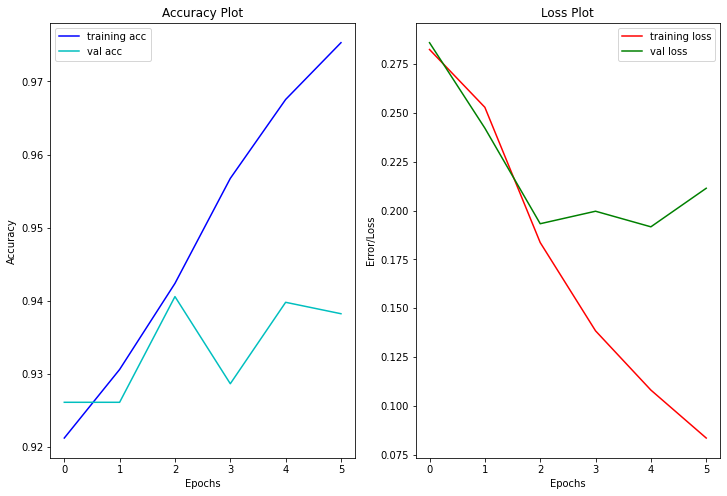

200/200 [==============================] - 3s 16ms/step - loss: 0.1927 - accuracy: 0.9438
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5949
           1       0.64      0.43      0.52       444

    accuracy                           0.94      6393
   macro avg       0.80      0.71      0.74      6393
weighted avg       0.94      0.94      0.94      6393


Accuracy 0.9438448302831222
LSTM: non hate - hate
precision: [0.95849738 0.64309764]
recall: [0.98218188 0.43018018]
fscore: [0.9701951  0.51551957]
support: [5949  444]

Confusion Matrix: 
 [[5843  106]
 [ 253  191]]


In [ ]:
trained_model = train_model(lstm_model, x_train, y_train, x_test, y_test, set_batch_size=128)

In [ ]:
trained_model.save('lstm_model_kaggle.h5')

Train the model without updating the weights of the Embedding Layer

In [ ]:
lstm_model = get_lstm_model(vocab_size, 50, 64, embeddings_weight=embedding_matrix, weight_trainable=False)
x_train, x_test, y_train, y_test = process_data(data)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 64)            1514944   
                                                                 
 dropout_14 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 128)           98816     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 50)                6450      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 50)                0         
                                                      

Epoch 1/6
80/80 [==============================] - 41s 216ms/step - loss: 0.2830 - accuracy: 0.9291 - val_loss: 0.2826 - val_accuracy: 0.9261
Epoch 2/6
80/80 [==============================] - 17s 209ms/step - loss: 0.2658 - accuracy: 0.9306 - val_loss: 0.2913 - val_accuracy: 0.9261
Epoch 3/6
80/80 [==============================] - 17s 208ms/step - loss: 0.2639 - accuracy: 0.9306 - val_loss: 0.2858 - val_accuracy: 0.9261
Epoch 4/6
80/80 [==============================] - 17s 213ms/step - loss: 0.2617 - accuracy: 0.9306 - val_loss: 0.2764 - val_accuracy: 0.9261
Epoch 5/6
80/80 [==============================] - 16s 204ms/step - loss: 0.2597 - accuracy: 0.9306 - val_loss: 0.2826 - val_accuracy: 0.9261
Epoch 6/6
80/80 [==============================] - 17s 208ms/step - loss: 0.2579 - accuracy: 0.9306 - val_loss: 0.2709 - val_accuracy: 0.9261


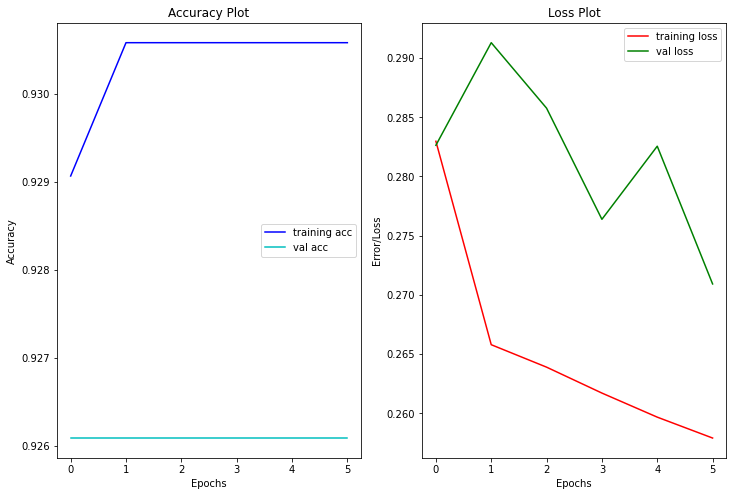

200/200 [==============================] - 3s 16ms/step - loss: 0.2633 - accuracy: 0.9305
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5949
           1       0.00      0.00      0.00       444

    accuracy                           0.93      6393
   macro avg       0.47      0.50      0.48      6393
weighted avg       0.87      0.93      0.90      6393


Accuracy 0.9305490380103237
LSTM: non hate - hate
precision: [0.93054904 0.        ]
recall: [1. 0.]
fscore: [0.96402528 0.        ]
support: [5949  444]

Confusion Matrix: 
 [[5949    0]
 [ 444    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
trained_model = train_model(lstm_model, x_train, y_train, x_test, y_test, set_batch_size=256, num_epochs=6)

### GloVE Pretrained Embedding

---


Set the weight of embedding layers equal to embedding weights coming from pretrained file, and do not change the weights during training.


You can download the file from: https://nlp.stanford.edu/projects/glove/


In [ ]:
import gensim
embedding_dim = 50
glove_file = "/content/gdrive/MyDrive/GloveEmbeddings/glove.twitter.27B." + str(embedding_dim) + "d.txt"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(glove_file)

In [ ]:
def get_embedding(word, n):
    try:
        return word2vec_model[word], n
    except Exception as e:
        # print('Encoding not found: %s' %(word))
        # Return 0 if the embedding does not exist
        return np.zeros(embedding_dim), n+1

In [ ]:
# Reference: [1] Pinkesh et. al. https://github.com/pinkeshbadjatiya/twitter-hatespeech
def get_embedding_weights(vocab):
    embedding = np.zeros((len(vocab) + 1, embedding_dim))
    n = 0
    cnt = 0
    for k, v in vocab.items():
        try:
            embedding[v], cnt = get_embedding(k, cnt)
        except Exception as e:
            n += 1
            pass
    print("%d embedding missed"%n)
    print("%d embedding not found!"%cnt)
    return embedding

#### Train the model

In [ ]:
vocabulary, reverse_vocabulary, frequenices = get_vocab(data['tokenized_sents'])
print('Length of vocabulary: ', len(vocabulary))
pretrained_embeddings_weights = get_embedding_weights(vocabulary)
x_train, x_test, y_train, y_test = process_data(data)
lstm_model = get_lstm_model(len(vocabulary) + 1, 50, 50, embeddings_weight=pretrained_embeddings_weights, weight_trainable=True)

Length of vocabulary:  23672
0 embedding missed
12291 embedding not found!
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 50, 50)            1183650   
                                                                 
 dropout_44 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 50, 128)           91648     
                                                                 
 global_max_pooling1d_22 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_44 (Dense)            (None, 50)                6450      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 50)     

We do not expect a great result as most of the words are missing in the GloVE embedding.

Epoch 1/6
320/320 [==============================] - 72s 216ms/step - loss: 0.2759 - accuracy: 0.9302 - val_loss: 0.2632 - val_accuracy: 0.9261
Epoch 2/6
320/320 [==============================] - 68s 212ms/step - loss: 0.2362 - accuracy: 0.9307 - val_loss: 0.2115 - val_accuracy: 0.9269
Epoch 3/6
320/320 [==============================] - 69s 214ms/step - loss: 0.1884 - accuracy: 0.9370 - val_loss: 0.1892 - val_accuracy: 0.9396
Epoch 4/6
320/320 [==============================] - 68s 214ms/step - loss: 0.1589 - accuracy: 0.9470 - val_loss: 0.1863 - val_accuracy: 0.9425
Epoch 5/6
320/320 [==============================] - 68s 214ms/step - loss: 0.1383 - accuracy: 0.9533 - val_loss: 0.1811 - val_accuracy: 0.9425
Epoch 6/6
320/320 [==============================] - 68s 211ms/step - loss: 0.1226 - accuracy: 0.9590 - val_loss: 0.1833 - val_accuracy: 0.9370


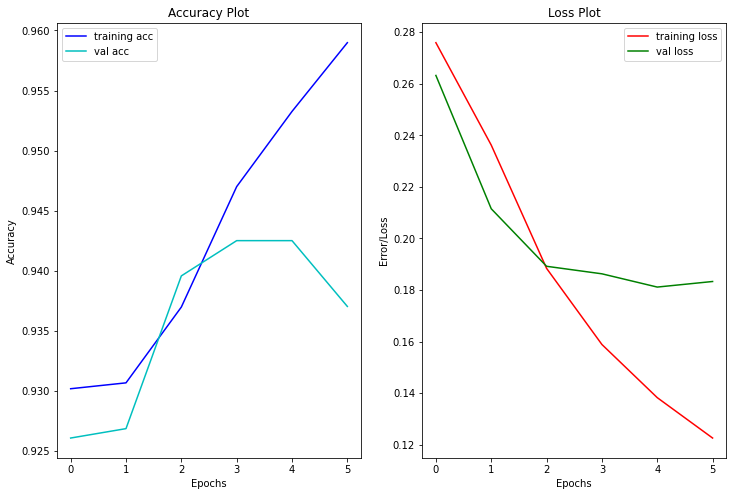

200/200 [==============================] - 3s 16ms/step - loss: 0.1717 - accuracy: 0.9435
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5949
           1       0.63      0.44      0.52       444

    accuracy                           0.94      6393
   macro avg       0.80      0.71      0.75      6393
weighted avg       0.94      0.94      0.94      6393


Accuracy 0.9435319881119975
LSTM: non hate - hate
precision: [0.95923734 0.63430421]
recall: [0.98100521 0.44144144]
fscore: [0.96999917 0.52058433]
support: [5949  444]

Confusion Matrix: 
 [[5836  113]
 [ 248  196]]


In [ ]:
trained_model = train_model(lstm_model, x_train, y_train, x_test, y_test)

### BILSTM Training on KAGGLE Dataset

In [ ]:
x_train, x_test, y_train, y_test = process_data(data)
bilstm_model = get_bilstm_model(len(vocabulary) - 1, 50, 64, embeddings_weight=embedding_matrix, weight_trainable=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 64)            1514944   
                                                                 
 dropout_16 (Dropout)        (None, 50, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          197632    
 l)                                                              
                                                                 
 global_max_pooling1d_8 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 50)                12850     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 50)              

Epoch 1/6
160/160 [==============================] - 73s 428ms/step - loss: 0.2754 - accuracy: 0.9286 - val_loss: 0.2694 - val_accuracy: 0.9261
Epoch 2/6
160/160 [==============================] - 68s 426ms/step - loss: 0.2319 - accuracy: 0.9324 - val_loss: 0.2051 - val_accuracy: 0.9341
Epoch 3/6
160/160 [==============================] - 67s 420ms/step - loss: 0.1572 - accuracy: 0.9493 - val_loss: 0.1816 - val_accuracy: 0.9421
Epoch 4/6
160/160 [==============================] - 67s 419ms/step - loss: 0.1211 - accuracy: 0.9611 - val_loss: 0.1852 - val_accuracy: 0.9425
Epoch 5/6
160/160 [==============================] - 67s 417ms/step - loss: 0.0952 - accuracy: 0.9708 - val_loss: 0.1998 - val_accuracy: 0.9366
Epoch 6/6
160/160 [==============================] - 69s 432ms/step - loss: 0.0755 - accuracy: 0.9772 - val_loss: 0.2181 - val_accuracy: 0.9321


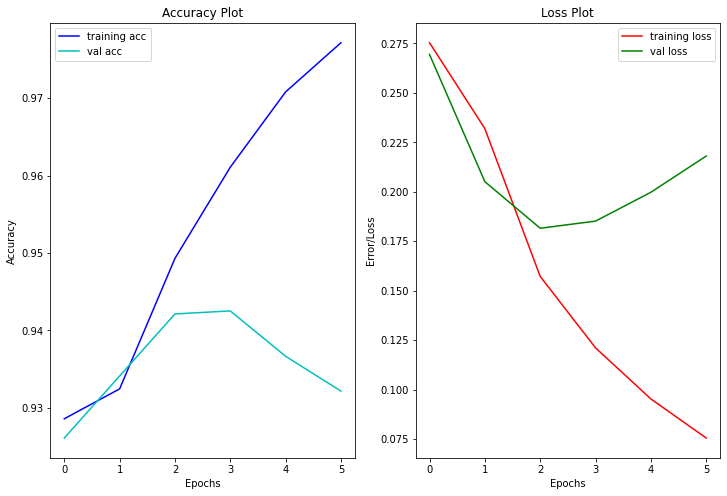

200/200 [==============================] - 6s 30ms/step - loss: 0.2023 - accuracy: 0.9382
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5949
           1       0.57      0.45      0.50       444

    accuracy                           0.94      6393
   macro avg       0.76      0.71      0.73      6393
weighted avg       0.93      0.94      0.93      6393


Accuracy 0.9382136712028781
LSTM: non hate - hate
precision: [0.95946393 0.57020057]
recall: [0.97478568 0.4481982 ]
fscore: [0.96706412 0.50189155]
support: [5949  444]

Confusion Matrix: 
 [[5799  150]
 [ 245  199]]


In [ ]:
trained_model = train_model(bilstm_model, x_train, y_train, x_test, y_test, set_batch_size=128)

In [ ]:
vocabulary, reverse_vocabulary, frequenices = get_vocab(data['tokenized_sents'])
print('Length of vocabulary: ', len(vocabulary))
pretrained_embeddings_weights = get_embedding_weights(vocabulary)
x_train, x_test, y_train, y_test = process_data(data)
bilstm_model = get_bilstm_model(len(vocabulary) + 1, 50, 50, embeddings_weight=pretrained_embeddings_weights, weight_trainable=True)

Length of vocabulary:  23672
0 embedding missed
12291 embedding not found!
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 50, 50)            1183650   
                                                                 
 dropout_46 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50, 128)           91648     
                                                                 
 global_max_pooling1d_23 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_46 (Dense)            (None, 50)                6450      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 50)     

Epoch 1/6
320/320 [==============================] - 70s 211ms/step - loss: 0.2804 - accuracy: 0.9272 - val_loss: 0.2701 - val_accuracy: 0.9261
Epoch 2/6
320/320 [==============================] - 67s 209ms/step - loss: 0.2425 - accuracy: 0.9308 - val_loss: 0.2127 - val_accuracy: 0.9288
Epoch 3/6
320/320 [==============================] - 66s 207ms/step - loss: 0.1826 - accuracy: 0.9390 - val_loss: 0.1905 - val_accuracy: 0.9398
Epoch 4/6
320/320 [==============================] - 68s 211ms/step - loss: 0.1539 - accuracy: 0.9488 - val_loss: 0.1857 - val_accuracy: 0.9394
Epoch 5/6
320/320 [==============================] - 67s 210ms/step - loss: 0.1377 - accuracy: 0.9544 - val_loss: 0.1850 - val_accuracy: 0.9368
Epoch 6/6
320/320 [==============================] - 66s 208ms/step - loss: 0.1224 - accuracy: 0.9598 - val_loss: 0.1858 - val_accuracy: 0.9402


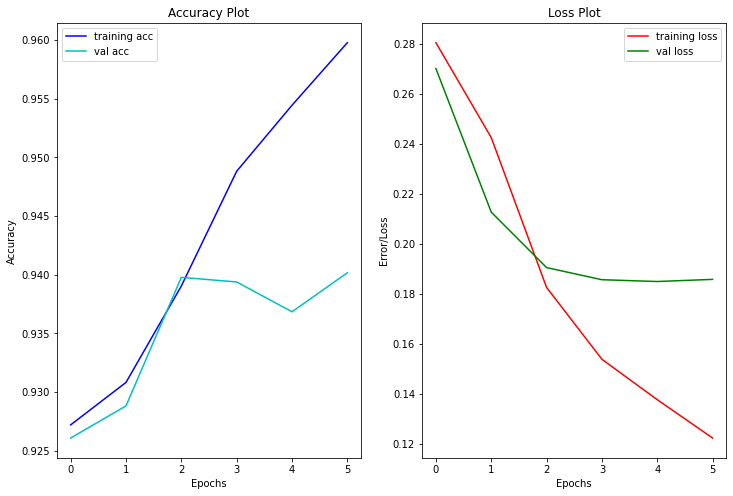

200/200 [==============================] - 3s 16ms/step - loss: 0.1757 - accuracy: 0.9442
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5949
           1       0.66      0.40      0.50       444

    accuracy                           0.94      6393
   macro avg       0.81      0.69      0.73      6393
weighted avg       0.94      0.94      0.94      6393


Accuracy 0.9441576724542469
LSTM: non hate - hate
precision: [0.95641528 0.66292135]
recall: [0.98487141 0.39864865]
fscore: [0.97043478 0.4978903 ]
support: [5949  444]

Confusion Matrix: 
 [[5859   90]
 [ 267  177]]


In [ ]:
trained_model = train_model(bilstm_model, x_train, y_train, x_test, y_test)